In [36]:
from astropy.io import fits
import astropy.table
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import math
import os,sys,random,time
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
import scipy.stats as ss
from astropy.modeling import models, fitting
import depthcalc
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.path as mpath
import scipy as sp
import math as m

In [37]:
#Open and input the catalog file and other relevant files like photovalues


#hard to open these images for the photvals bc need to transfer big fits 
#so here are the photvals
#but you can extract them as above

original_red_image="/home/k689j329/HSTdata/j210604m5845/j210604m5845-f105w_drz_sci.fits"
fileblue="/home/k689j329/HSTdata/j2106_blue2red_exact_conv_apr21_5.fits"
convd_blue_image="/home/k689j329/HSTdata/j210604m5845/j210604m5845-f606w_drc_sci.fits"
original_hdu=fits.open(original_red_image)
blue_hdu=fits.open(convd_blue_image)
ohdr=original_hdu[0].header
bhdr=blue_hdu[0].header
photvals=[ohdr['PHOTFLAM'],ohdr['PHOTPLAM']]
photvalsb=[bhdr['PHOTFLAM'],bhdr['PHOTPLAM']]
#print(photvals)
#print(photvalsb)

#photvals=[3.0386574e-20, 10551.047]
#photvalsb=[7.7893479e-20, 5921.9492]

catname='catalog_dualmode_j210604m5845.fits'
t=Table.read(catname,format='fits')
print(t.colnames)

#filter out the not-star and not-contaminated objects
noflags= (t['SEFLAGS_f105w'] < 0.5) & (t['SEFLAGS_f606w'] < 0.5)
notstars=(t['CLASS_STAR_f105w'] < 0.8) & (t['CLASS_STAR_f606w'] < 0.8)
goodweights=(t['F105w_normweight'] < 1.0) & (t['F606w_normweight'] < 1.0)
noprob= noflags & notstars & goodweights
formernoprob=notstars & noflags

print(np.size(t[formernoprob]),np.size(t[noprob]))


['SE_ID_f105w', 'X_IMAGE_f105w', 'Y_IMAGE_f105w', 'ALPHA_J2000_f105w', 'DELTA_J2000_f105w', 'SEFLAGS_f105w', 'CLASS_STAR_f105w', 'FLUX_AUTO_f105w', 'FLUXERR_AUTO_f105w', 'FLUX_ISO_f105w', 'FLUXERR_ISO_f105w', 'FLUX_APER_f105w', 'FLUXERR_APER_f105w', 'FWHM_IMAGE_f105w', 'KRON_RADIUS_f105w', 'ISOAREA_IMAGE_f105w', 'A_IMAGE_f105w', 'B_IMAGE_f105w', 'THETA_IMAGE_f105w', 'X_IMAGE_f606w', 'Y_IMAGE_f606w', 'ALPHA_J2000_f606w', 'DELTA_J2000_f606w', 'SEFLAGS_f606w', 'CLASS_STAR_f606w', 'FLUX_AUTO_f606w', 'FLUXERR_AUTO_f606w', 'FLUX_ISO_f606w', 'FLUXERR_ISO_f606w', 'FLUX_APER_f606w', 'FLUXERR_APER_f606w', 'FWHM_IMAGE_f606w', 'KRON_RADIUS_f606w', 'ISOAREA_IMAGE_f606w', 'A_IMAGE_f606w', 'B_IMAGE_f606w', 'THETA_IMAGE_f606w', 'F105w_normweight', 'F606w_normweight']
891 863


In [38]:
#FIND SPECTROSCOPICALLY CONFIRMED MEMBERS/NONMEMBERS OF THE GOGREEN DATA AND COMPARE 

##this opens the gogreen data file
gogreen='/home/k689j329/database/gogreen_photometry.fits'
gg=fits.open(gogreen)
datagg=gg[1].data


data_j2106=datagg.Cluster == 'SPT2106'
j21_hold=datagg[data_j2106]
good_zspec1 = (j21_hold.Redshift_Quality == 4) | (j21_hold.Redshift_Quality == 3)
#print(np.size(datagg[data_j2106]),np.size(datagg[data_j2106][good_zspec1]))
#print(datagg[data_j2106][good_zspec1]['zspec'])


##this matches the gogreen ra and dec to the ra and dec of our catalog

gg_cat=SkyCoord(ra=datagg[data_j2106][good_zspec1]['ra']*u.degree,dec=datagg[data_j2106][good_zspec1]['dec']*u.degree)

t_cat=SkyCoord(ra=t['ALPHA_J2000_f105w']*u.degree,dec=t['DELTA_J2000_f105w']*u.degree)

idx,d2d,d3d=gg_cat.match_to_catalog_sky(t_cat,nthneighbor=1)

nearby = d2d < 1.0*u.arcsec





#how good are positions?
#plt.plot(t[idx]['DELTA_J2000'],t[idx]['ALPHA_J2000']-datagg[data_j2106][good_zspec1]['ra'],'mo')
#plt.plot(t[idx[nearby]]['DELTA_J2000'],t[idx[nearby]]['ALPHA_J2000']-datagg[data_j2106][good_zspec1][nearby]['ra'],'c.')
#plt.show()
#plt.plot(d2d[nearby],'b.')
#plt.ylabel('distance between matches (arcsec)')
#plt.show()

#how good are positions2?
#plt.plot(t[noprob]['ALPHA_J2000'],t[noprob]['DELTA_J2000'],'k+',alpha=0.5,label='high quality dual-mode SE-detected sources from HST')
#plt.plot(datagg[data_j2106][good_zspec1]['ra'],datagg[data_j2106][good_zspec1]['dec'],'D',color='indigo',label='GoGreen sources that matched with the high quality SE data')
#plt.plot(datagg[data_j2106][good_zspec1][nearby]['ra'],datagg[data_j2106][good_zspec1][nearby]['dec'],'.',color='cyan',label='Sources matched GoGreen with separation <1" ')
#plt.title('Comparison between catalogs--GoGreen positions')
#plt.xlabel('ALPHA_J2000')
#plt.ylabel('DEC_J2000')
#plt.legend()
#plt.show()

#how good are positions3?
#plt.plot(t[noprob]['ALPHA_J2000'],t[noprob]['DELTA_J2000'],'k+',alpha=0.5,label='high quality dual-mode SE-detected sources from HST')
#plt.plot(t[idx]['ALPHA_J2000'],t[idx]['DELTA_J2000'],'D',color='indigo',label='Sources matched with GoGreen catalog')
#plt.plot(t[idx][nearby]['ALPHA_J2000'],t[idx][nearby]['DELTA_J2000'],'.',color='cyan',label='Sources matched GoGreen with proximity of <1" ')
#plt.title('Comparison between catalogs--SE generated positions')
#plt.xlabel('ALPHA_J2000')
#plt.ylabel('DEC_J2000')
#plt.legend(prop={"size":8})
#plt.show()


/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


STDEV of all "valid" pixels in scidata: 0.0024854857416880703
rms actual (square root of the mean of the squared values of all valid data points): 0.002497132541572541
flux lim b 0.032842763053125
flux lim b better units? 0.002992605299704551
obar blue 0.00022647539705731546


/home/k689j329/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in log10


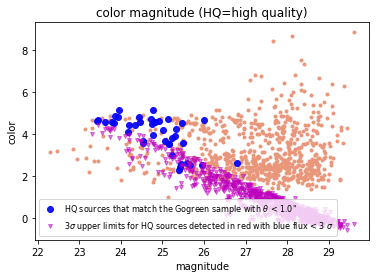

In [47]:
#need phot_f_lambda and phot_p_lambda to run depthcalc.depth()
# note these equations are derived from
#https://hst-docs.stsci.edu/wfc3dhb/chapter-9-wfc3-data-analysis/9-1-wfc3-data-analysis
# https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration
##USE AUTO FOR MAG, NOT APER
#USE APER FOR COLORS

#making the color and the mag for the color-mag diagram
abmagzpt_red=-2.5*np.log10(photvals[0]) - 21.10 - 5.0*np.log10(photvals[1]) + 18.692
abmagzpt_blue=-2.5*np.log10(photvalsb[0]) - 21.10 - 5.0*np.log10(photvalsb[1]) + 18.692
#abmag_depth=-2.5*np.log10(5.0*stdev_empty)+abmagzpt #only do this to get 5-sigma measures of ABdepth (5*stdev)
red_abmag=-2.5*np.log10(t['FLUX_APER_f105w'])+abmagzpt_red
blue_abmag=-2.5*np.log10(t['FLUX_APER_f606w'])+abmagzpt_blue

#3-sigma flux limit
#o(N) = obarA + obarBN + obarCN^2
#signal variation (o) as a function of aperture size
#so, I know obarA (=0), obarB= 0.01246307609; and obarC = 0.0002696116525 all from empty aperture fitting, in the catalog
#just need N, the aperture size that pertains.
#which is 5.0 pixels (default_dualimage.sex)
#okay but is that radius or diameter?


#aHA is this counts or flux? I bet its counts
fluxlimb=(0.01246307609 *2.5) + (0.0002696116525*6.25)
#first, since these C1 and C2 values include obar (the rms) in them, they are probably in units of counts not flux
#next, should probably include weights from weight column should be included,right?
#BUT, should this really be the equation for the error at a given object source in the image?
#or should it be obar, the rms
#honestly I think it should be obar
#****
photflam_red=photvals[0]
photflam_blue=photvalsb[0]
photplam_red=photvals[1]
photplam_blue=photvalsb[1]
c_ang=sp.constants.c * (10.0**10.0)
conversion=((photplam_red*photplam_red)/c_ang)*(1.0/(10.0**(-23.0)))*(10.0**6.0)
convb=((photplam_blue*photplam_blue)/c_ang)*(1.0/(10.0**(-23.0)))*(10.0**6.0)
#fileredmask='/home/k689j329/HSTdata/j210604m5845/j210604m5845-f105w_drz_sci_mask.fits'
#fileredseg='/home/k689j329/HSTdata/j210604m5845/j210604m5845_f105w_seg_newnorm3.fits'
#obar_counts_f105w,useless=depthcalc.rmscalc(original_red_image,fileredmask,fileredseg,[5,10])
#obar_f105w=obar_counts_f105w**photflam_red*conversion
filebluemask='/home/k689j329/HSTdata/j2106_blue2red_exact_conv_apr21_5_mask.fits'
fileblueseg='/home/k689j329/sextractor-2.19.5/j2106_b2rec_apr21_5_seg.fits'
obar_counts_f606w,useless=depthcalc.rmscalc(fileblue,filebluemask,fileblueseg,[5,10])
obar_f606w=obar_counts_f606w*photflam_blue*convb

wi1=t['F606w_normweight']*(29770.775825471697) #this is wb10pct, so turning these back into straight weights
deno=np.sqrt(wi1)
#****can replace the above (between the ****) with obar_f105w and obar_f606w from metatable
#original:
fluxlimb=(0.01246307609 *2.5) + (0.0002696116525*2.5*2.5)
# convert the units
fluxlim2blue=(0.01246307609*(photflam_blue*convb) *2.5) + (0.0002696116525*(photflam_blue*convb)*2.5*2.5)
# include weights?
fluxlimbwi = 0

print('flux lim b', fluxlimb)
print('flux lim b better units?',fluxlim2blue)
print('obar blue',obar_f606w)

threesigma=fluxlimb*3.0
lowblueflux= t[noprob]['FLUX_APER_f606w'] < threesigma
test_lbf=noprob & (t['FLUX_APER_f606w'] < threesigma)
test_hbf= noprob & (t['FLUX_APER_f606w'] >= threesigma)
alternativelowbluemag=-2.5*np.log10(threesigma)+abmagzpt_blue
altcolor=alternativelowbluemag-red_abmag

#print(np.size(red_abmag), np.size(blue_abmag))
color=blue_abmag-red_abmag
mag=-2.5*np.log10(t['FLUX_AUTO_f105w'])+abmagzpt_red

#symb=u'\u2193'
#plt.plot(mag[test_hbf],color[test_hbf],'c*',label='all HQ sources detected in red with blue flux >= 3 $\sigma$')
#plt.plot(mag[test_lbf],color[test_lbf],'r+',label='all HQ sources detected in red with blue flux < 3 $\sigma$, colors uncorrected')
plt.plot(mag[noprob],color[noprob],'.',color='darksalmon')
#plt.plot(mag[idx],color[idx],'o',color='darksalmon',label='HQ sources that match the GoGreen sample')
plt.plot(mag[idx[nearby]],color[idx[nearby]],'bo',alpha=0.9,label='HQ sources that match the Gogreen sample with $\u03B8$ < 1.0"')
plt.plot(mag[test_lbf],altcolor[test_lbf],'mv',markersize=4,alpha=0.5,label='3$\sigma$ upper limits for HQ sources detected in red with blue flux < 3 $\sigma$')
plt.xlabel('magnitude')
plt.ylabel('color')
plt.legend(loc='lower left',prop={'size': 8})
plt.title('color magnitude (HQ=high quality)')
plt.show()


In [78]:
####GOGREEN COLOR MAGNITUDE DIAGRAM
#okay, not a good one for comparison bc can't average V and r bands bc there appears to be no V band data for J2106

#Xdownload gogreen data for j2106
#Xmatch it to my 'good data' above
#see what that color mag diagram looks like given bands that are 'as close as possible'
##Compare I(GOGREEN) to xF814x or F606(HST) and compare J1(GOGREEN) to F105W(HST)
#To measure “total” fluxes in J1 that are analogous to your AUTO fluxes in F105W, do the following:
#fJ1_tot = FOURSTARJ1 * HAWKIKs_tot / HAWKIKs
#This takes the aperture flux in J1 (like a Y-band at 1um) and scales it by the ratio of the AUTO 
#K-band flux to the aperture K-band flux.  This basically scales the J1 aperture flux to a total 
#magnitude under the assumption that the spatial profiles of light in the K and J1 bands have similar shapes.
#Then you can compute the magnitude using 
#mJ1_tot = -2.5 * log10(fJ1_tot) + 25

#well, this gogreen data doesn't have HAWKIKs n stuff
#and my data is for F606, which will require me to average the V and R band colors

#avg_blue = (0.5 * (datagg[data_j2106]['r_tot'] + datagg[data_j2106]['V_tot']))



-0.2330533739992375 nan


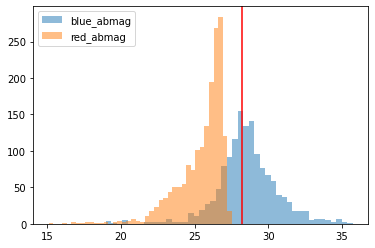

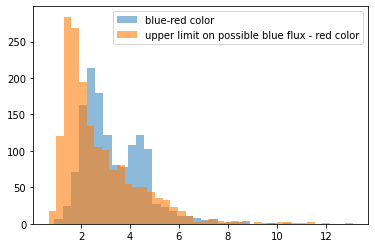

In [11]:
####note: problem fixed by not plotting sources twice, once with incorrect colors and once with correct colors

#trying to figure out Greg's concerns over upper plot: 
#Then I don’t understand what you mean by ‘detected’ and ‘non-detected’, how that relates to your point 
#color in the plot from last week, and how/when you move things to be on the red line
#Every object detected in the red band but with a blue band to the right of the line should be labeled as a 
#lower limit on the color, where the red mag is the measured mag and the blue mag is the limit for the 
#blue filter (red line.)  Then the color will be: color = blue(lim) - red(measured)

#Again, look at the faint red objects that are very red but which you say are “detected” and which 
#ave a much redder color than the things you say are “non-detected” and tell me why; 
#I'm talking, e.g. about all the cyan points at mag=25-26 but colors>4

n,bins,patches=plt.hist(x=blue_abmag,bins='auto',alpha=0.5,label='blue_abmag')
n,bins,patches=plt.hist(x=red_abmag,bins='auto',alpha=0.5,label='red_abmag')
plt.axvline(x=alternativelowbluemag,color='red')
plt.legend(loc='upper left')
plt.show()

n,bins,patchs=plt.hist(x=color,bins='auto',alpha=0.5,label='blue-red color')
n,bins,patchss=plt.hist(x=altcolor,bins='auto',alpha=0.6,label='upper limit on possible blue flux - red color')
plt.legend(loc='upper right')
plt.show()